In [1]:
import pickle

import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline


In [431]:
import glob
image_files = glob.glob('./sample_dataset/*.png')

images = []
for fname in image_files:
    img = cv2.imread(fname)
    images.append(img)
    
print(len(images))

image = images[0]
image.shape

82


(500, 500, 4)

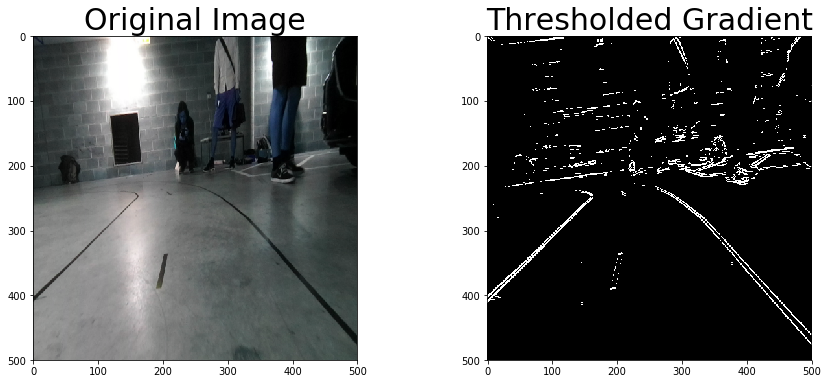

In [45]:
%matplotlib inline

image = images[0]
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    
    # Convert to HLS and use lightness as the gray
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    L = hls[:,:,1]
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    if orient=='x':
        sobel = cv2.Sobel(L, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    else:
        sobel = cv2.Sobel(L, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    binary_output = sxbinary
    return binary_output

# Run the function
grad_binary = abs_sobel_thresh(image, orient='y', thresh=(20, 100))

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(grad_binary, cmap='gray')
ax2.set_title('Thresholded Gradient', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

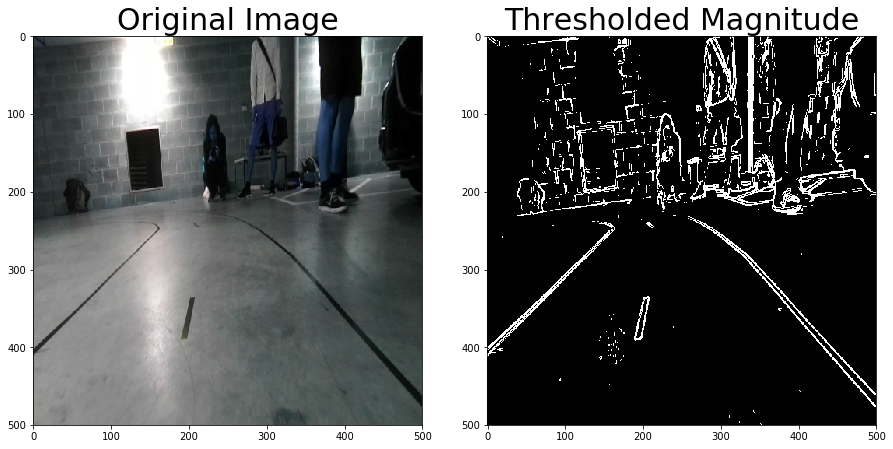

In [52]:
# Define a function that applies Sobel x and y, 
# then computes the magnitude of the gradient
# and applies a threshold
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    
    # Convert to HLS and use lightness as the gray
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    L = hls[:,:,1]
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(L, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(L, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Calculate the magnitude 
    mag = np.sqrt(np.square(sobelx) + np.square(sobely))
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    
    scaled_mag = np.uint8(255*mag/np.max(mag))
    # 5) Create a binary mask where mag thresholds are met
    sxbinary = np.zeros_like(scaled_mag)
    sxbinary[(scaled_mag >= mag_thresh[0]) & (scaled_mag <= mag_thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    binary_output = sxbinary # Remove this line
    return binary_output
    
# Run the function
mag_binary = mag_thresh(image, sobel_kernel=3, mag_thresh=(20, 100))
# print(mag_binary)
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(mag_binary, cmap='gray')
ax2.set_title('Thresholded Magnitude', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

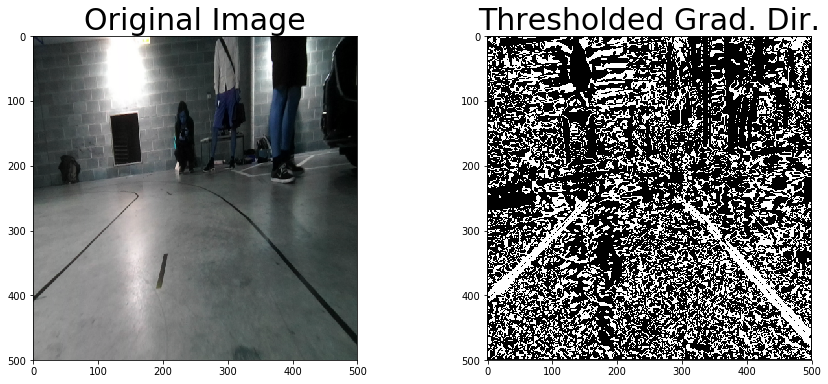

In [66]:
# Define a function that applies Sobel x and y, 
# then computes the direction of the gradient
# and applies a threshold.
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    
    # Convert to HLS and use lightness as the gray
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    L = hls[:,:,1]
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(L, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(L, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Take the absolute value of the x and y gradients
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    G = np.arctan2(abs_sobely, abs_sobelx)
    # 5) Create a binary mask where direction thresholds are met
    mask = np.zeros_like(G)
    mask[(G > thresh[0]) & (G < thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    binary_output = mask
    return binary_output
    
# Run the function
dir_binary = dir_threshold(image, sobel_kernel=15, thresh=(0.4, 1.))
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dir_binary, cmap='gray')
ax2.set_title('Thresholded Grad. Dir.', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

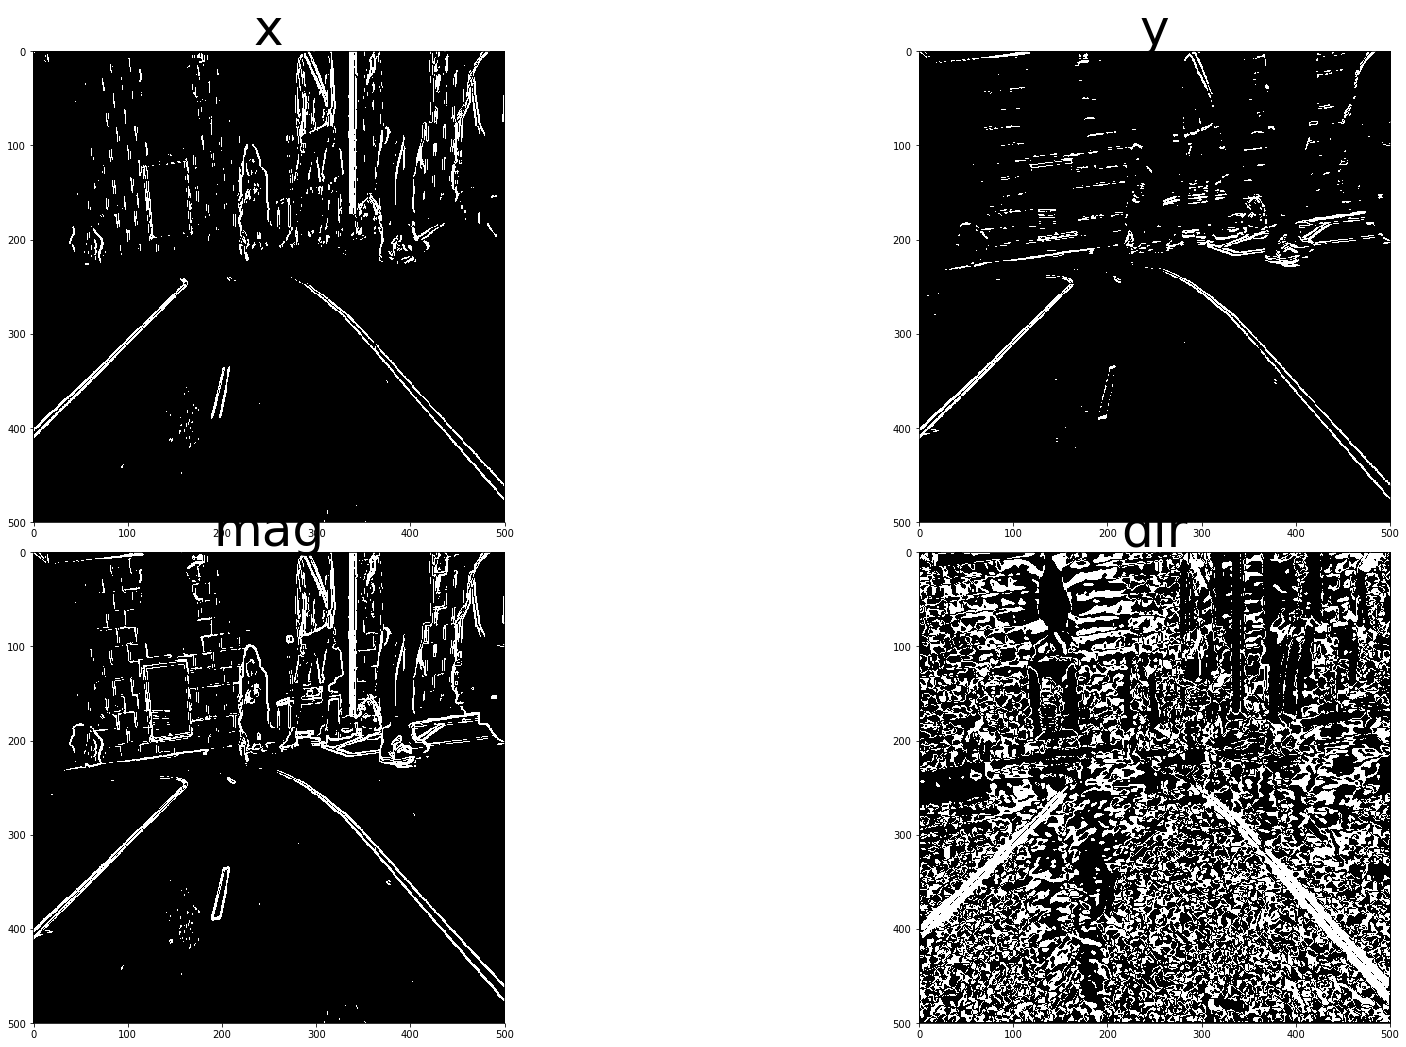

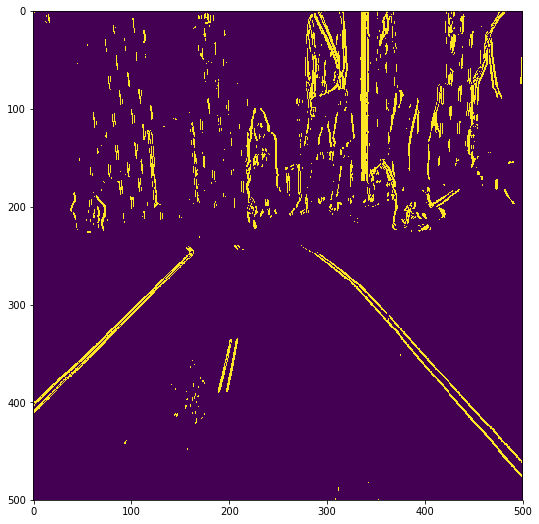

In [68]:
%matplotlib inline

image = images[0]

x_grad_binary = abs_sobel_thresh(image, orient='x', thresh=(20, 100))
y_grad_binary = abs_sobel_thresh(image, orient='y', thresh=(20, 100))
mag_binary = mag_thresh(image, sobel_kernel=3, mag_thresh=(20, 100))
dir_binary = dir_threshold(image, sobel_kernel=15, thresh=(.4, 1.))

f, ax = plt.subplots(2, 2, figsize=(24, 15))
f.tight_layout()
ax[0][0].imshow(x_grad_binary, cmap='gray')
ax[0][0].set_title('x', fontsize=50)
ax[0][1].imshow(y_grad_binary, cmap='gray')
ax[0][1].set_title('y', fontsize=50)

ax[1][0].imshow(mag_binary, cmap='gray')
ax[1][0].set_title('mag', fontsize=50)
ax[1][1].imshow(dir_binary, cmap='gray')
ax[1][1].set_title('dir', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


binary = np.zeros_like(dir_binary)
binary[(x_grad_binary == 1) & (mag_binary == 1)] = 1

plt.figure(2)
f, ax1 = plt.subplots(1, 1, figsize=(24, 9))
ax1.imshow(binary)

[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]


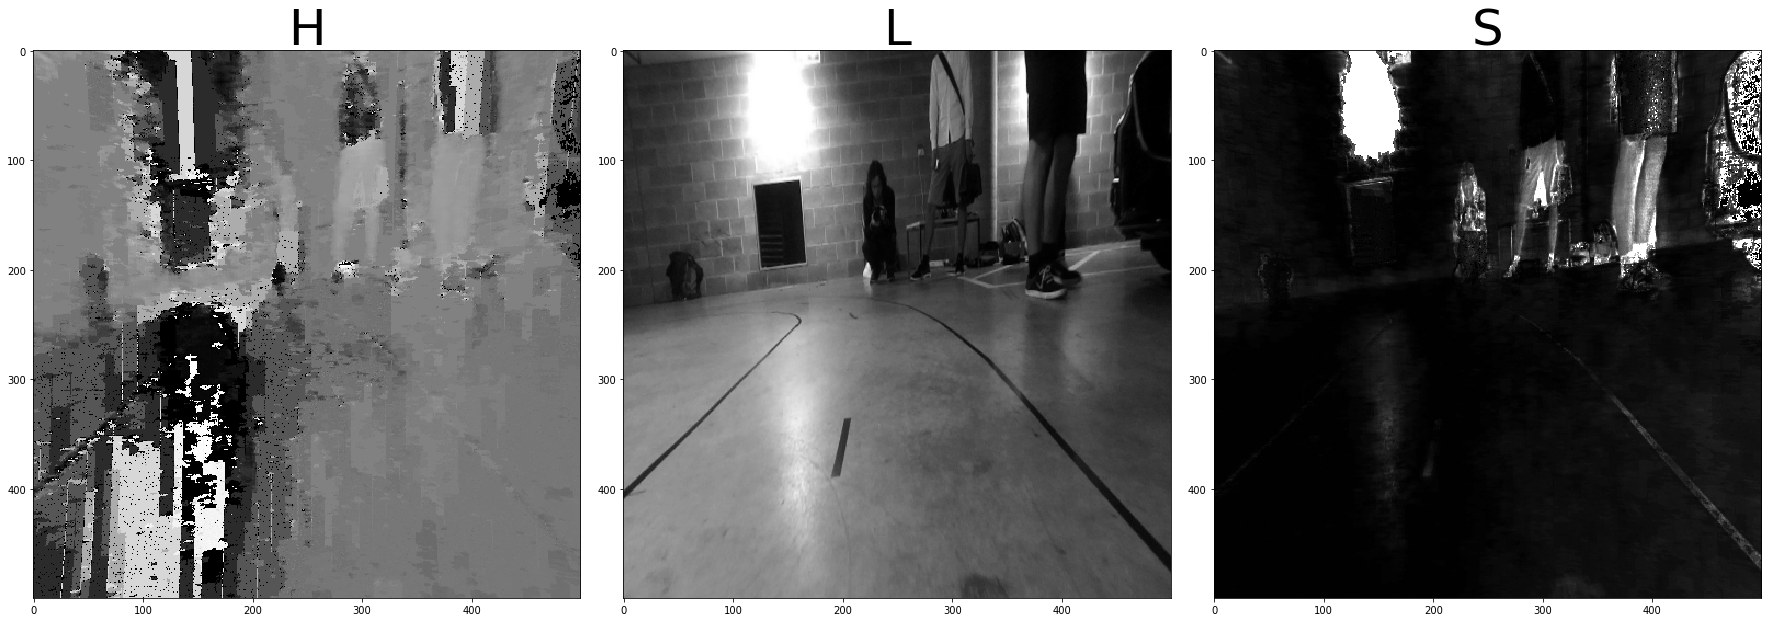

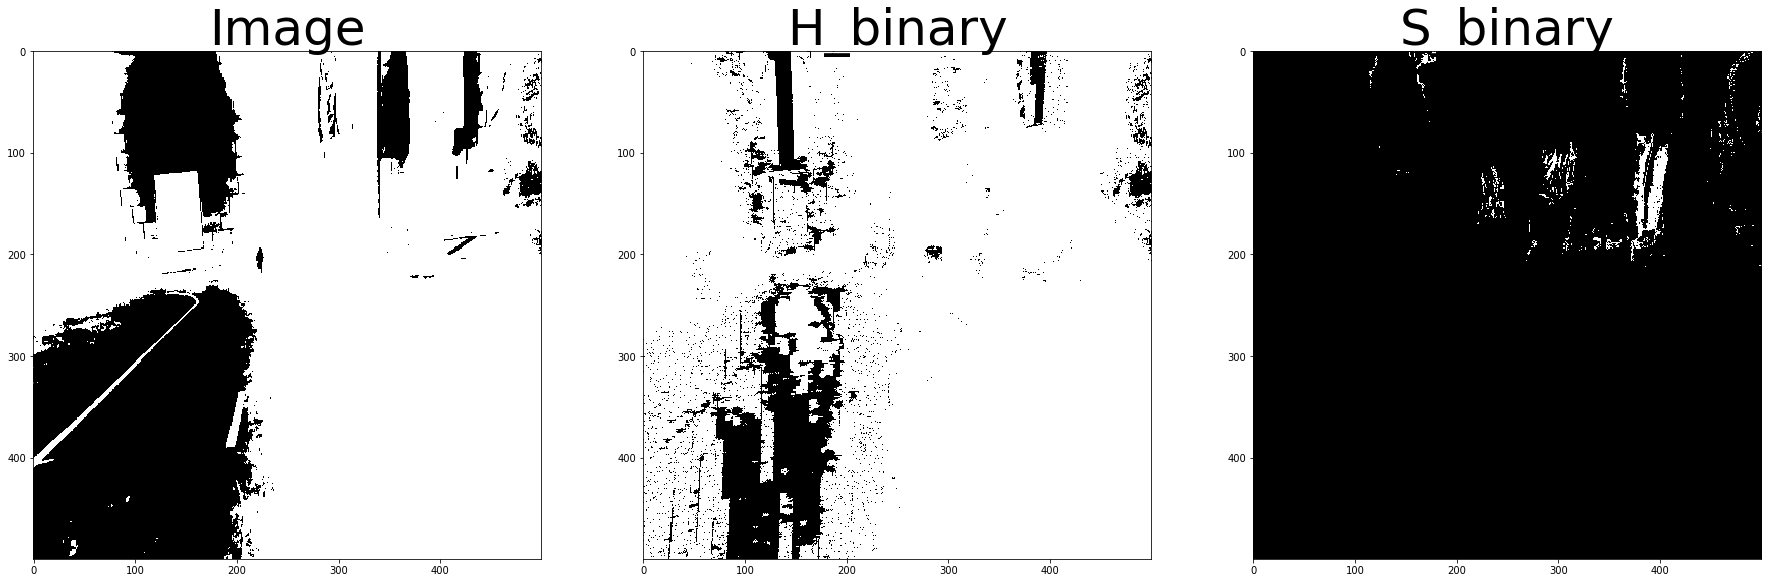

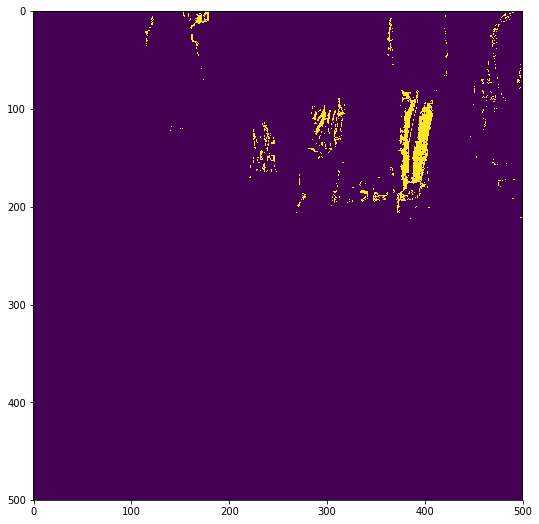

In [147]:
%matplotlib inline

image = images[0]
hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
H = hls[:,:,0]
L = hls[:,:,1]
S = hls[:,:,2]

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))
f.tight_layout()
ax1.imshow(H, cmap='gray')
ax1.set_title('H', fontsize=50)
ax2.imshow(L, cmap='gray')
ax2.set_title('L', fontsize=50)
ax3.imshow(S, cmap='gray')
ax3.set_title('S', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

plt.figure(1)

H_thresh = (0, 255)
H_binary = np.zeros_like(H)
H_binary[(H > H_thresh[0]) & (H <= H_thresh[1])] = 1

S_thresh = (0.5, .9)
S_binary = np.zeros_like(S)
S_binary[(S > S_thresh[0]) & (S <= S_thresh[1])] = 1

L_thresh = (0., .5)
L_binary = np.zeros_like(L)
L_binary[(L > L_thresh[0]) & (L <= L_thresh[1])] = 1
print(S_binary)

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))

ax1.imshow(L_binary, cmap='gray')
ax1.set_title('Image', fontsize=50)
ax2.imshow(H_binary, cmap='gray')
ax2.set_title('H_binary', fontsize=50)
ax3.imshow(S_binary, cmap='gray')
ax3.set_title('S_binary', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


binary = np.zeros_like(S)
binary[(S_binary == 1) & (H_binary == 1)] = 1
plt.figure(2)
f, ax1 = plt.subplots(1, 1, figsize=(24, 9))
ax1.imshow(binary)

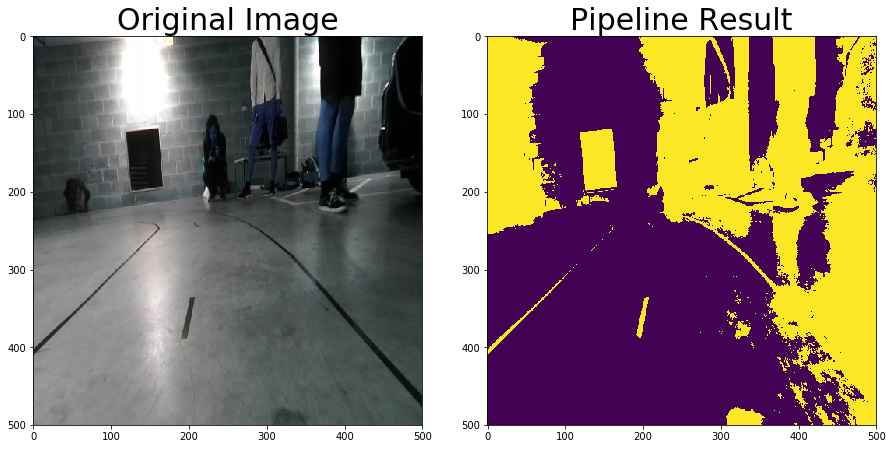

In [409]:
%matplotlib inline

image = images[0]
# image = plt.imread('./output_images/575_before.jpg')
def hsl_channel_threshold(img, l_thresh=(0.,.5)):
#     img = np.copy(img)

    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hls[:,:,1]
    
    # Threshold lightness channel
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel > l_thresh[0]) & (l_channel <= l_thresh[1])] = 1

    return l_binary
    
result = hsl_channel_threshold(image, l_thresh=(0., .3))   #dark is towards 0

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
f.tight_layout()

ax1.imshow(image)
ax1.set_title('Original Image', fontsize=30)

ax2.imshow(result)
ax2.set_title('Pipeline Result', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [12]:
# !ls zed

import glob
image_files = glob.glob('./zed/*.jpg')

images = []
for fname in image_files:
    img = cv2.imread(fname)
    images.append(img)
    
print(len(images))

image = images[0]
image.shape

# image = plt.imread("./zed/zed2.png")
# print image.shape
# plt.imshow(image)

2


(376, 672, 3)

(500, 500, 4)


CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 5.96 ms


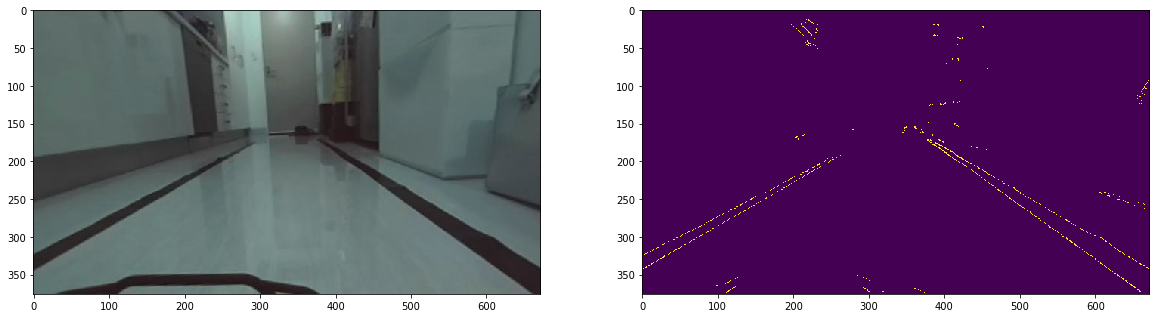

In [59]:
image = images[1]

def abs_sobel_thresh(hls, orient='x', sobel_kernel=3, thresh=(0, 255)):

    # Convert to HLS and use lightness as the gray
    L = hls[:,:,1]
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    if orient=='x':
        sobel = cv2.Sobel(L, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    else:
        sobel = cv2.Sobel(L, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    binary_output = sxbinary
    return binary_output

def hsl_channel_threshold(hls, l_thresh=(0.,.5)):
    l_channel = hls[:,:,1]

    # Threshold lightness channel
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel > l_thresh[0]) & (l_channel <= l_thresh[1])] = 1

    return l_binary

def filter_lanes(image):
    x_grad_binary = abs_sobel_thresh(image, orient='x', thresh=(20, 80))
    y_grad_binary = abs_sobel_thresh(image, orient='y', thresh=(20, 80))
    hsl_channel_binary = hsl_channel_threshold(image, l_thresh=(0., 50))

    combined = np.zeros_like(x_grad_binary) #this makes it 1 channel
#     combined[(x_grad_binary == 1)] = 1
#     combined[(y_grad_binary == 1)] = 1
#     combined[(y_grad_binary == 1) & (x_grad_binary == 1)] = 1
#     combined[(y_grad_binary == 1) | (x_grad_binary == 1)] = 1
#     combined[(mag_binary == 1)] = 1
#     combined[(dir_binary == 1)] = 1
#     combined[(hsl_channel_binary == 1)] = 1
    combined[(hsl_channel_binary == 1) & (x_grad_binary == 1) & (y_grad_binary == 1)] = 1   
#     combined[(hsl_channel_binary == 1) & (x_grad_binary == 1) & (y_grad_binary == 1) & (dir_binary == 1)] = 1   
#     combined[((y_grad_binary == 1) | (x_grad_binary == 1)) & (hsl_channel_binary == 1)] = 1
#     combined[(dir_binary == 1) & (hsl_channel_binary == 1)] = 1

    return combined


def plot_images(image1, image2):
    plt.figure(figsize=(20,20))
    plt.subplot(1, 2, 1)
    plt.imshow(image1)
    plt.subplot(1, 2, 2)
    plt.imshow(image2)
    
hls = cv2.cvtColor(image, cv2.COLOR_BGR2HLS).astype(np.float)
# image = image[:, :, [2, 1, 0]]
# plt.imshow(image)

# print(hls)
%time modified = filter_lanes(hls)
plot_images(image, modified)

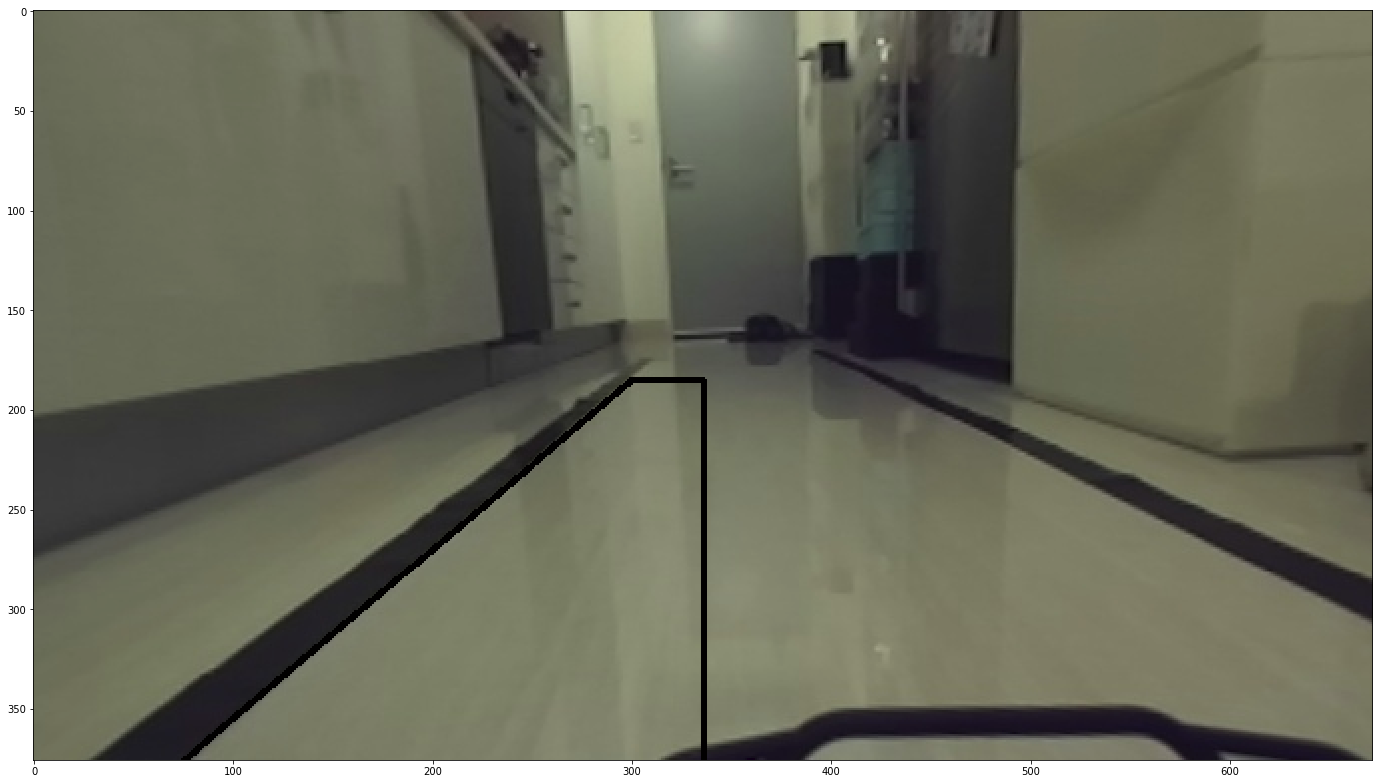

In [534]:
#left
left_image = np.copy(images[1])
def show_warp_lines_left(image):
    color=[255, 0, 0]
    warp_vertices_src = [(75, image.shape[0]), (300, 185), (336, 185), (336, image.shape[0])]
    cv2.line(image, warp_vertices_src[0], warp_vertices_src[1], color, 2)
    cv2.line(image, warp_vertices_src[2], warp_vertices_src[3], color, 2)
    cv2.line(image, warp_vertices_src[1], warp_vertices_src[2], color, 2)
    return image

left_image = show_warp_lines_left(left_image)

f, ax = plt.subplots(1, 1, figsize=(24,24))
ax.imshow(left_image)

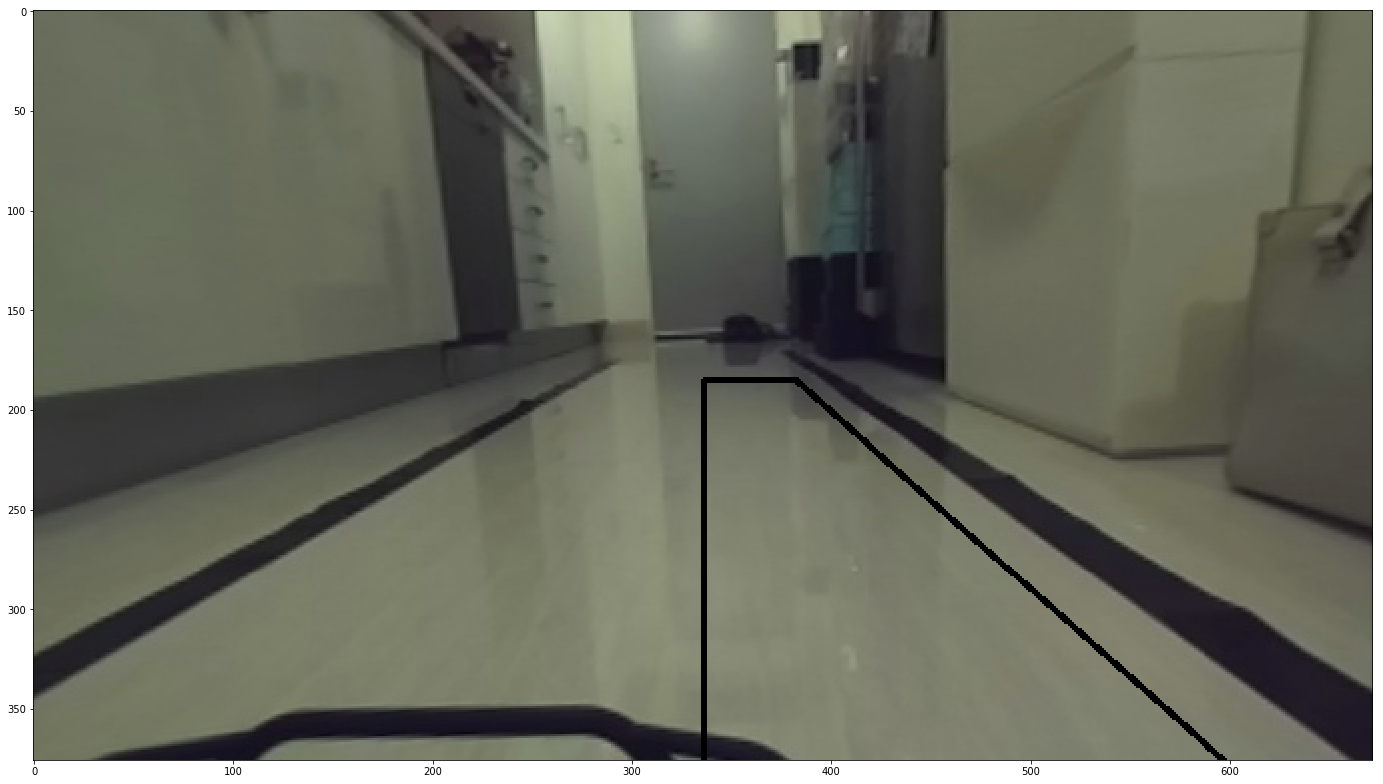

In [760]:
#right
right_image = np.copy(images[0])
def show_warp_lines_left(image):
    color=[255, 0, 0]
    warp_vertices_src = [(597, image.shape[0]), (382, 185), (336, 185), (336, image.shape[0])]
    cv2.line(image, warp_vertices_src[0], warp_vertices_src[1], color, 2)
    cv2.line(image, warp_vertices_src[2], warp_vertices_src[3], color, 2)
    cv2.line(image, warp_vertices_src[1], warp_vertices_src[2], color, 2)
    return image

right_image = show_warp_lines_left(right_image)

f, ax = plt.subplots(1, 1, figsize=(24,24))
ax.imshow(right_image)

(376, 672, 3)


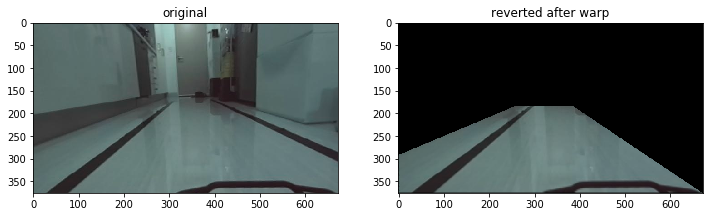

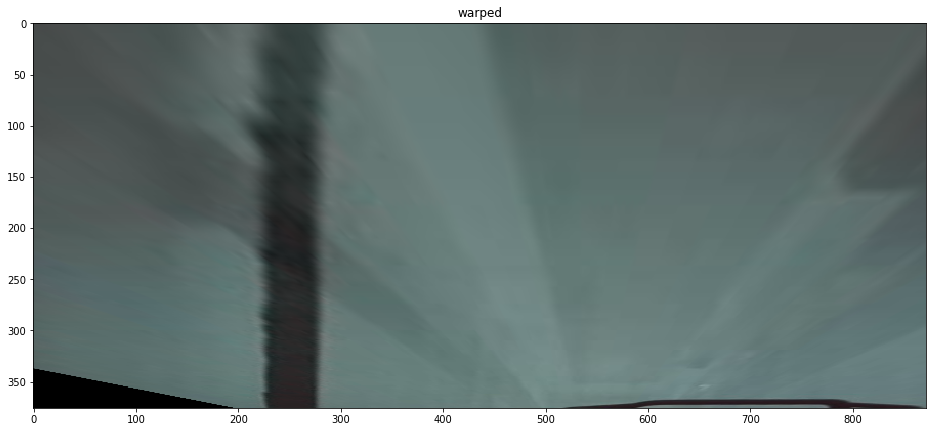

In [61]:
def warp_image(image, mode='normal', side="left"):
    image = np.copy(image)
    if side == "left":
        warp_vertices_src = [(75, image.shape[0]), (297, 185), (336, 185), (336, image.shape[0])]
        src = np.float32(warp_vertices_src)
        dst = np.float32([[275, image.shape[0]], [275, 0], [536, 0], [536, image.shape[0]]])
    else:
        warp_vertices_src = [(597, image.shape[0]), (382, 185), (336, 185), (336, image.shape[0])]
        src = np.float32(warp_vertices_src)
        dst = np.float32([[597, image.shape[0]], [597, 0], [336, 0], [336, image.shape[0]]])

#     color=[255, 0, 0]
#     cv2.line(image, warp_vertices_src[0], warp_vertices_src[1], color, 1)
#     cv2.line(image, warp_vertices_src[2], warp_vertices_src[3], color, 1)
#     cv2.line(image, warp_vertices_src[1], warp_vertices_src[2], color, 1)
        
    if mode=='normal':
        M = cv2.getPerspectiveTransform(src, dst)
        warped = cv2.warpPerspective(image, M, (872, 376), flags=cv2.INTER_LINEAR)
    elif mode=='inverse':
        M = cv2.getPerspectiveTransform(dst, src)
        warped = cv2.warpPerspective(image, M, (672, 376), flags=cv2.INTER_LINEAR)
    return warped

image = images[0]
print(image.shape)
warped = warp_image(image, side="left")
warped_inverse = warp_image(warped, mode='inverse', side="left")
f, ax = plt.subplots(1, 2, figsize=(12,12))
ax[0].imshow(image)
ax[0].set_title('original')
ax[1].imshow(warped_inverse)
ax[1].set_title('reverted after warp')
plt.figure(figsize=(16,8))
plt.title('warped')
plt.imshow(warped)

(376, 672, 3)


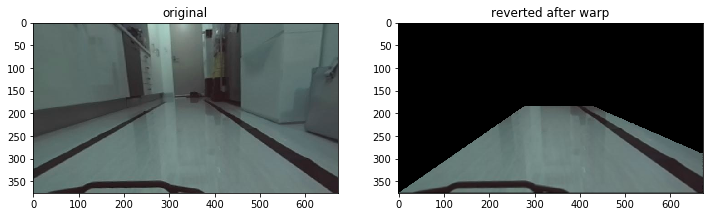

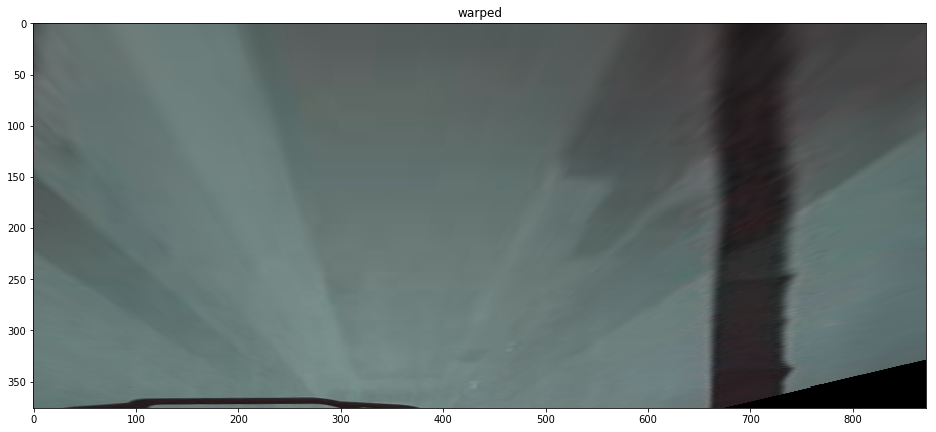

In [62]:
image = images[1]
print(image.shape)
warped = warp_image(image, side="right")
# warped_inverse = warp_image(warped, mode='inverse', side="left")
warped_inverse = warp_image(warped, mode='inverse', side="right")
f, ax = plt.subplots(1, 2, figsize=(12,12))
ax[0].imshow(image)
ax[0].set_title('original')
ax[1].imshow(warped_inverse)
ax[1].set_title('reverted after warp')
plt.figure(figsize=(16,8))
plt.title('warped')
plt.imshow(warped)

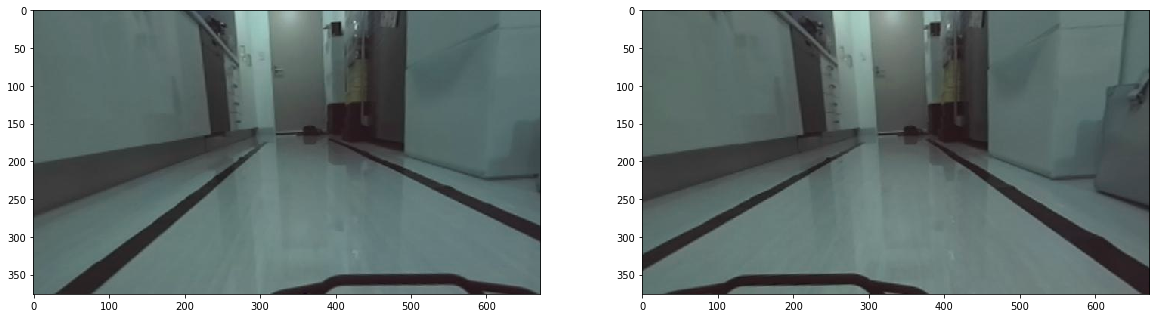

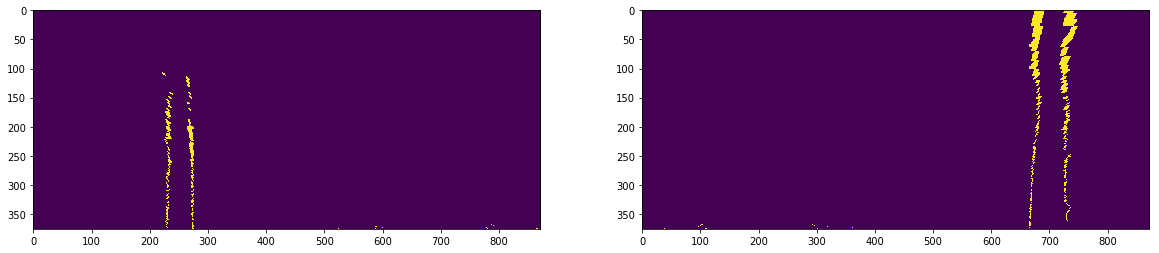

In [63]:
left_image = images[0]
left_filtered = filter_lanes(left_image)
left_warped = warp_image(left_filtered, side="left")

right_image = images[1]
right_filtered = filter_lanes(right_image)
right_warped = warp_image(right_filtered, side="right")

plot_images(left_image, right_image)
plot_images(left_warped, right_warped)

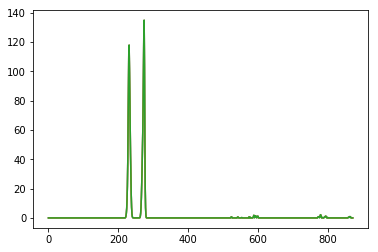

In [620]:
image = images[1]
filtered = filter_lanes(image)
warped = warp_image(filtered)

histogram = np.sum(warped[warped.shape[0]/2:,:], axis=0)
plt.plot(histogram)

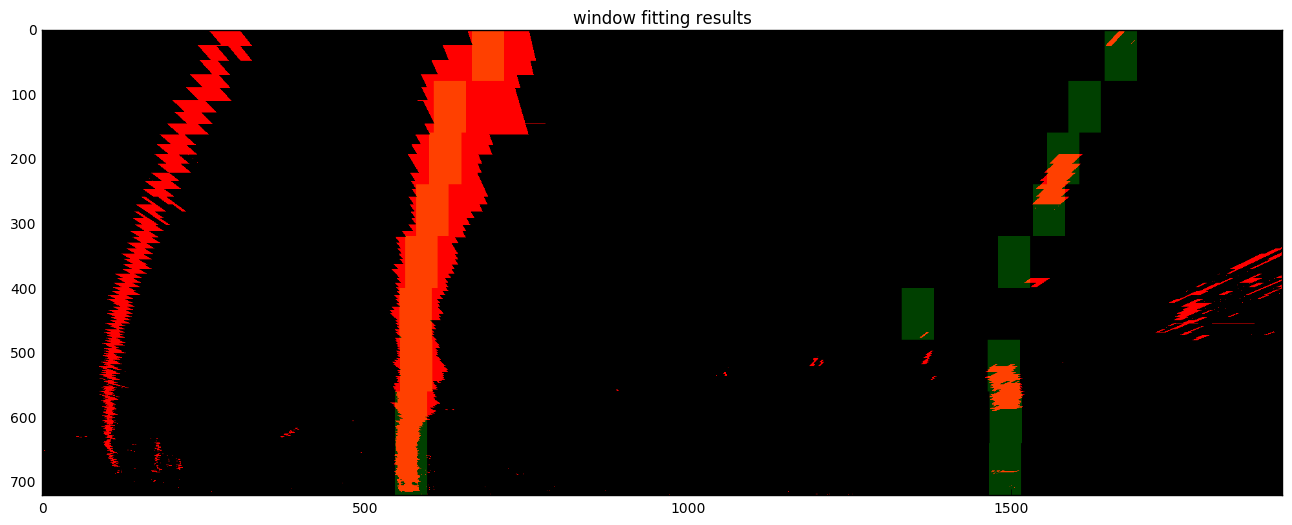

In [15]:
def find_lane_pixels(warped):
    # window settings
    window_width = 50 
    window_height = 80 # Break image into 9 vertical layers since image height is 720
    margin = 150 # How much to slide left and right for searching

    def window_mask(width, height, img_ref, center,level):
        output = np.zeros_like(img_ref)
        output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),max(0,int(center-width/2)):min(int(center+width/2),img_ref.shape[1])] = 1
        return output

    def find_window_centroids(image, window_width, window_height, margin):

        window_centroids = [] # Store the (left,right) window centroid positions per level
        window = np.ones(window_width) # Create our window template that we will use for convolutions

        # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
        # and then np.convolve the vertical image slice with the window template 

        # Sum quarter bottom of image to get slice, could use a different ratio
        l_sum = np.sum(warped[int(6*warped.shape[0]/10):,:int(warped.shape[1]/2)], axis=0)
        l_center = np.argmax(np.convolve(window,l_sum))-window_width/2
        r_sum = np.sum(warped[int(6*warped.shape[0]/10):,int(warped.shape[1]/2):], axis=0)
        r_center = np.argmax(np.convolve(window,r_sum))-window_width/2+int(warped.shape[1]/2)
#         print(r_center)
        
        # Add what we found for the first layer
        window_centroids.append((l_center,r_center))

        # Go through each layer looking for max pixel locations
        for level in range(1,(int)(warped.shape[0]/window_height)):
            # convolve the window into the vertical slice of the image
            image_layer = np.sum(warped[int(warped.shape[0]-(level+1)*window_height):int(warped.shape[0]-level*window_height),:], axis=0)
            conv_signal = np.convolve(window, image_layer)
            # Find the best left centroid by using past left center as a reference
            # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
            offset = window_width/2
            l_min_index = int(max(l_center+offset-margin,0))
            l_max_index = int(min(l_center+offset+margin,warped.shape[1]))
            l_signal_center = np.argmax(conv_signal[l_min_index:l_max_index]) 
            if l_signal_center > 0:
                l_center = l_signal_center+l_min_index-offset
            # Find the best right centroid by using past right center as a reference
            r_min_index = int(max(r_center+offset-margin,0))
            r_max_index = int(min(r_center+offset+margin,warped.shape[1]))
            r_signal_center = np.argmax(conv_signal[r_min_index:r_max_index])
            
#             print(level, r_min_index, r_max_index, r_signal_center)
            if r_signal_center > 0:
                r_center = r_signal_center+r_min_index-offset
            # Add what we found for that layer
            window_centroids.append((l_center,r_center))

        return window_centroids

    window_centroids = find_window_centroids(warped, window_width, window_height, margin)

    # If we found any window centers
    if len(window_centroids) > 0:

        # Points used to draw all the left and right windows
        l_points = np.zeros_like(warped)
        r_points = np.zeros_like(warped)

        # Go through each level and draw the windows 
        for level in range(0,len(window_centroids)):
            # Window_mask is a function to draw window areas
            l_mask = window_mask(window_width,window_height,warped,window_centroids[level][0],level)
            r_mask = window_mask(window_width,window_height,warped,window_centroids[level][1],level)
            # Add graphic points from window mask here to total pixels found 
            l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
            r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255

        # Draw the results
        template = np.array(r_points+l_points,np.uint8) # add both left and right window pixels together
        zero_channel = np.zeros_like(template) # create a zero color channle 
        template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8) # make window pixels green
        warpage = np.array(cv2.merge((warped,warped,warped)),np.uint8) # making the original road pixels 3 color channels
        output = cv2.addWeighted(warpage, 1, template, 0.5, 0.0) # overlay the orignal road image with window results

    # If no window centers found, just display orginal road image
    else:
        output = np.array(cv2.merge((warped,warped,warped)),np.uint8)
        
    return l_points, r_points, output

image = images[5]
# image = plt.imread('./output_images/172_before.jpg')
image = cv2.undistort(image, mtx, dist, None, mtx)
filtered = filter_lanes(image)
warped = warp_image(filtered)
l_points, r_points, output = find_lane_pixels(warped)

# Display the final results
plt.figure(figsize=(16,8))
warped[warped==1] = 255
warped = np.array(warped, np.uint8)
warped = np.array(cv2.merge((warped,np.zeros_like(warped),np.zeros_like(warped)))) # making the original road pixels 3 color channels
output = cv2.addWeighted(warped, 1, output, 0.5, 0)
plt.imshow(output)
plt.title('window fitting results')

In [691]:
a = np.array([[1,2],
              [3,4]])
# np.flip(a,0)
a[:, ::-1]

array([[2, 1],
       [4, 3]])

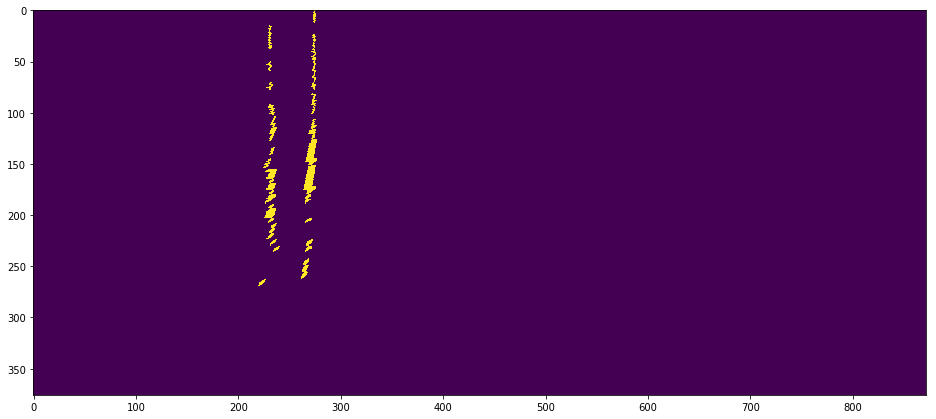

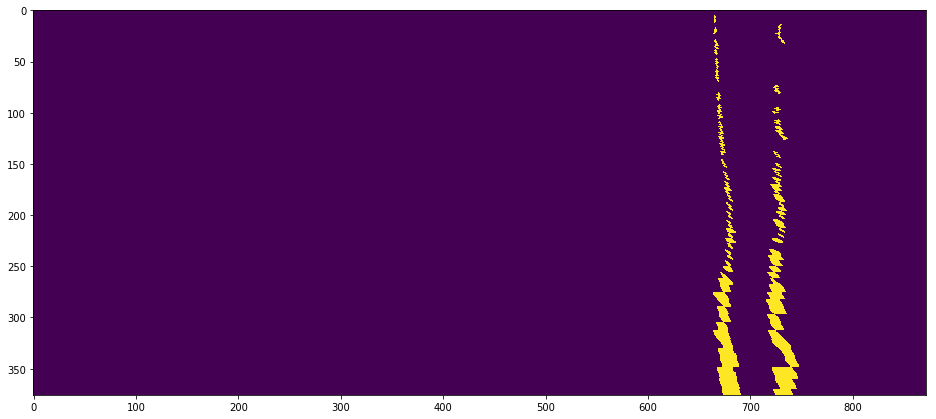

In [68]:
from scipy.ndimage.measurements import label
def clean_image(image):
    labels = label(image)  # labels[0] = image with labels, labels[1] = count of labels
    result = labels[0]
    
    for object_no in range(1, labels[1]+1):
        # Find pixels with each label value
        nonzero = (result == object_no).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        if ((np.max(nonzeroy)-np.min(nonzeroy)<5) & (np.max(nonzerox)-np.min(nonzerox)<5)):
            result[(result == object_no)] = 0
    result[result>0] = 1
    return result

left_clean = clean_image(left_warped)
left_clean = cv2.flip(left_clean, 0)
plt.figure(figsize=(16,8))
plt.imshow(left_clean)

right_clean = clean_image(right_warped)
right_clean = cv2.flip(right_clean, 0)
plt.figure(figsize=(16,8))
plt.imshow(right_clean)


(469.01026424809277, 0.0)


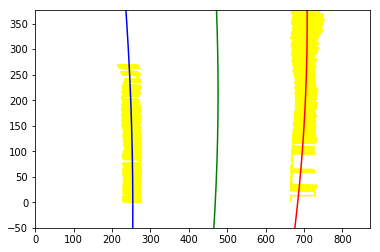

In [859]:
def get_line_fit(points, y_axis):
    y, x = np.nonzero(points)
    fit = np.polyfit(y, x, 2)
    line_fitx = fit[0]*y_axis**2 + fit[1]*y_axis + fit[2]
    return line_fitx

image_height = left_clean.shape[0]
y_axis = np.linspace(-50, image_height-1, num=image_height+50)
y, x = np.nonzero(left_clean)
left_fitx = get_line_fit(left_clean, y_axis)

plt.plot(x, y, color='yellow')
plt.plot(left_fitx, y_axis, color='blue')
plt.xlim(0, left_warped.shape[1])
plt.ylim(-50, image_height)


y, x = np.nonzero(right_clean)
right_fitx = get_line_fit(right_clean, y_axis)

plt.plot(x, y, color='yellow')
plt.plot(right_fitx, y_axis, color='red')


print(centre[50], y_axis[50])
centre = (left_fitx + right_fitx)/2
plt.plot(centre, y_axis, color='green')


# plt.gca().invert_yaxis() # to visualize as we do the images

(254.26162557260494, 683.75890292358065)
469.010264248
475


(-50, 376)

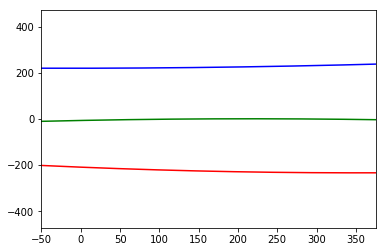

In [875]:
# centre point
middle_of_car = (250+700)/2
print(left_fitx[50], right_fitx[50])
print((left_fitx[50] + right_fitx[50])/2)
print(middle_of_car)

plt.plot(y_axis, (left_fitx-middle_of_car)*-1, color='blue')
plt.plot(y_axis, (right_fitx-middle_of_car)*-1, color='red')
plt.plot(y_axis, centre-middle_of_car, color='green')
plt.ylim(-472, 472)
plt.xlim(-50, 376)

In [23]:
import glob
import matplotlib.pyplot as plt
%matplotlib inline
image_files = glob.glob('./zed/*.jpg')

images = []
for fname in image_files:
    img = cv2.imread(fname)
    images.append(img)
    
print(len(images))
print(images[0].shape)

2
(376, 672, 3)


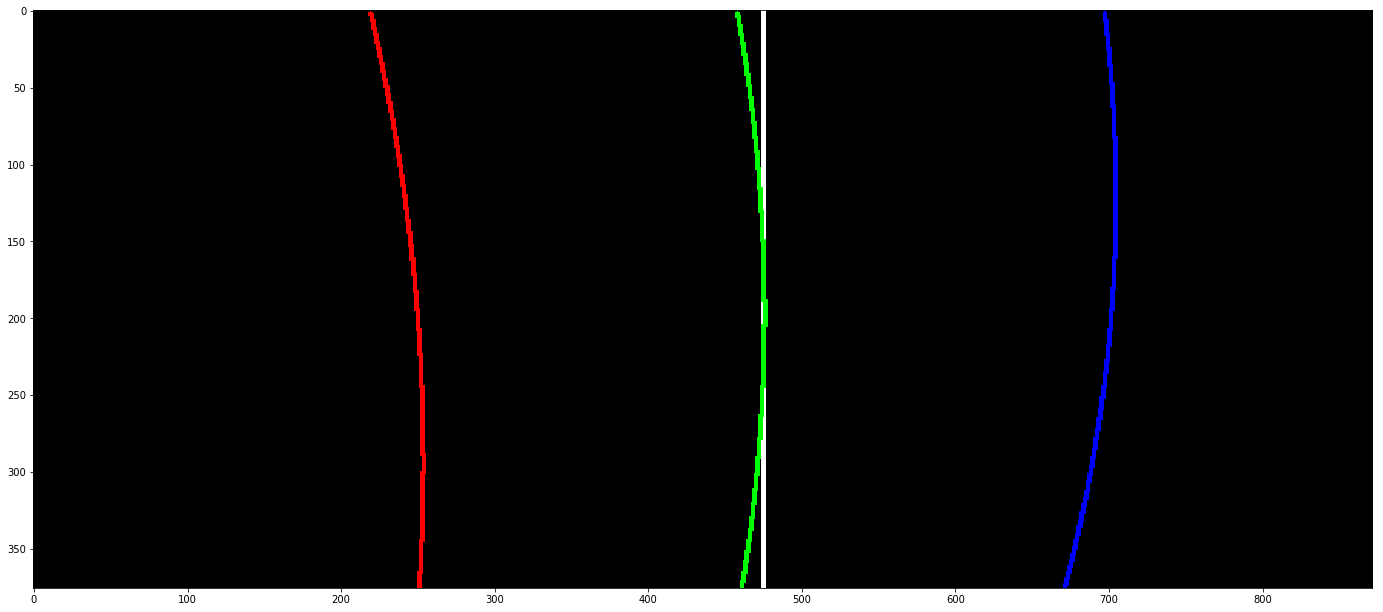

In [70]:
from scipy.ndimage.measurements import label
import cv2
import numpy as np

class LaneDetector():
    def __init__(self, debug=False):
        self.middle_of_car = (250+700)/2
        self.modified_width = 872
        self.modified_height = 376
        self.debug = debug
    
    def abs_sobel_thresh(self, hls, orient='x', sobel_kernel=3, thresh=(0, 255)):

        # Convert to HLS and use lightness as the gray
        L = hls[:,:,1]
        # 2) Take the derivative in x or y given orient = 'x' or 'y'
        if orient=='x':
            sobel = cv2.Sobel(L, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
        else:
            sobel = cv2.Sobel(L, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
        # 3) Take the absolute value of the derivative or gradient
        abs_sobel = np.absolute(sobel)
        # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
        scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
        # 5) Create a mask of 1's where the scaled gradient magnitude 
                # is > thresh_min and < thresh_max
        sxbinary = np.zeros_like(scaled_sobel)
        sxbinary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
        # 6) Return this mask as your binary_output image
        binary_output = sxbinary
        return binary_output

    def hsl_channel_threshold(self, hls, l_thresh=(0.,50)):
        l_channel = hls[:,:,1]

        # Threshold lightness channel
        l_binary = np.zeros_like(l_channel)
        l_binary[(l_channel > l_thresh[0]) & (l_channel <= l_thresh[1])] = 1

        return l_binary

    def filter_lanes(self, image):
        x_grad_binary = self.abs_sobel_thresh(image, orient='x', thresh=(20, 80))
        y_grad_binary = self.abs_sobel_thresh(image, orient='y', thresh=(20, 80))
        hsl_channel_binary = self.hsl_channel_threshold(image, l_thresh=(0., 50.))

        combined = np.zeros_like(x_grad_binary) #this makes it 1 channel
        combined[(hsl_channel_binary == 1) & (x_grad_binary == 1) & (y_grad_binary == 1)] = 1  

        return combined
    
    def warp_image(self, image, mode='normal', side="left"):
        image = np.copy(image)
        if side == "left":
            warp_vertices_src = [(75, image.shape[0]), (297, 185), (336, 185), (336, image.shape[0])]
            src = np.float32(warp_vertices_src)
            dst = np.float32([[275, image.shape[0]], [275, 0], [536, 0], [536, image.shape[0]]])
        else:
            warp_vertices_src = [(597, image.shape[0]), (382, 185), (336, 185), (336, image.shape[0])]
            src = np.float32(warp_vertices_src)
            dst = np.float32([[597, image.shape[0]], [597, 0], [336, 0], [336, image.shape[0]]])

        if mode=='normal':
            M = cv2.getPerspectiveTransform(src, dst)
            warped = cv2.warpPerspective(image, M, (872, 376), flags=cv2.INTER_LINEAR)
        elif mode=='inverse':
            M = cv2.getPerspectiveTransform(dst, src)
            warped = cv2.warpPerspective(image, M, (672, 376), flags=cv2.INTER_LINEAR)
        return warped

    def clean_image(self, image):
        labels = label(image)  # labels[0] = image with labels, labels[1] = count of labels
        result = labels[0]

        for object_no in range(1, labels[1]+1):
            # Find pixels with each label value
            nonzero = (result == object_no).nonzero()
            # Identify x and y values of those pixels
            nonzeroy = np.array(nonzero[0])
            nonzerox = np.array(nonzero[1])
            if ((np.max(nonzeroy)-np.min(nonzeroy)<5) & (np.max(nonzerox)-np.min(nonzerox)<5)):
                result[(result == object_no)] = 0
        result[result>0] = 1
        return result
    
    def get_line_fit(self, points, y_axis):
        y, x = np.nonzero(points)
        fit = np.polyfit(y, x, 2)
        line_fitx = fit[0]*y_axis**2 + fit[1]*y_axis + fit[2]
        return line_fitx
    
    def process_images(self, left, right):
        # convert to HLS
        left_image = cv2.cvtColor(left, cv2.COLOR_BGR2HLS).astype(np.float)
        right_image = cv2.cvtColor(right, cv2.COLOR_BGR2HLS).astype(np.float)
        
        #filter out lanes and warp it
        left_filtered = self.filter_lanes(left_image)
        left_warped = self.warp_image(left_filtered, side="left")
        right_filtered = self.filter_lanes(right_image)
        right_warped = self.warp_image(right_filtered, side="right")

        # clean and flip the image upside down to make the front of the car x = 0
        left_clean = self.clean_image(left_warped)
        left_clean = cv2.flip(left_clean, 0)
        right_clean = self.clean_image(right_warped)
        right_clean = cv2.flip(right_clean, 0)
        
        # fit a line to the left and right
        image_height = left_clean.shape[0]
        y_axis = np.linspace(-50, image_height-1, num=image_height+50)
        left_fitx = self.get_line_fit(left_clean, y_axis)
        right_fitx = self.get_line_fit(right_clean, y_axis)
        
        centre = (left_fitx + right_fitx)/2
        
        # translate this to have the front of the car to be the positive x-axis
        self.x_axis = y_axis
        self.left_y = (left_fitx - self.middle_of_car) * -1
        self.right_y = (right_fitx - self.middle_of_car) * -1
        self.centre = centre - self.middle_of_car
        
        if self.debug == True:
            image = np.zeros([self.modified_height, self.modified_width, 3], dtype=np.uint8)
            y_axis = y_axis[51:][::-1]
            cv2.line(image, (self.middle_of_car, 0), (self.middle_of_car, self.modified_height), (1,1,1), 2)
            points = np.vstack((left_fitx[51:], y_axis)).T.astype(np.int32)
            cv2.polylines(image, [points], False, (1,0,0), 2)
            points = np.vstack((right_fitx[51:], y_axis)).T.astype(np.int32)
            cv2.polylines(image, [points], False, (0,0,1), 2)
            points = np.vstack((centre[51:], y_axis)).T.astype(np.int32)
            cv2.polylines(image, [points], False, (0,1,0), 2)
            self.debug_image = image
        
    def get_path(self):
        return self.centre, self.y_axis
    
    def get_lanes(self):
        return self.left_y, self.right_y, self.x_axis
    
    def show_lanes_as_image(self):
        return self.debug_image
    
    
detector = LaneDetector(debug=True)

detector.process_images(images[0], images[1])
left_y, right_y, x_axis = detector.get_lanes()
out = detector.show_lanes_as_image()
plt.figure(figsize=(24,24))
plt.imshow(out)
# left_y = left_y[0:10]
# x_axis = x_axis[0:10]
# print(left_y, x_axis)

